In [1]:
import pandas as pd 
import numpy as np 
from math import sqrt

import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor

from sklearn.preprocessing import  StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('dataset.csv',index_col=0)

# Prepare data

In [4]:
df.drop(['date_install','first_command_time','birthday','sex','time_confirm_email'],axis=1,inplace=True)

In [5]:
int_cols = df.select_dtypes(include=['int', 'float']).columns
int_cols = int_cols.drop('target_game_currency')
obj_cols = ['country','network_name']

In [6]:
def prepare_obj_data(df, obj_cols):
    '''
    Prepare data with type object
    
    Args:
        df: pd.DataFrame
        obj_cols: list of str 
    Returns:
        pd.DataFrame
    '''
    
    cheat_count_is_cheater = df['is_cheater'].value_counts().index[0]
    cheat_count_has_email = df['has_email'].value_counts().index[0]
    
    df['is_cheater'] = df['is_cheater'].fillna(cheat_count_is_cheater)
    df['has_email'] = df['has_email'].fillna(cheat_count_has_email)
    
    df['country'] = df['country'].fillna('other')
    df['network_name'] = df['network_name'].fillna('other')

    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    for column in obj_cols:
        encoded_data = encoder.fit_transform(df[[column]])
        encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([column]))
        df = pd.concat([df, encoded_df], axis=1)
    
    df.drop(obj_cols, axis=1, inplace=True)
        
    return df


In [7]:
df = prepare_obj_data(df, obj_cols)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
X = df.drop('target_game_currency', axis = 1)
y = df['target_game_currency']

In [9]:
y_stratified = (y > 0).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y_stratified, random_state=42)


## Catboost

In [10]:
def plot_importance(model, X):
    '''
    Function for plot regression coef
    '''
    try:
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X.columns
        fold_importance_df["importance"] = model.feature_importances_
        td = fold_importance_df.sort_values('importance', ascending=False)
        sns.barplot(x="importance", y="feature", data=td.head(10), palette="Blues_d")
        plt.show()
    except:
        return []

In [11]:
def SMAPE(y_true, y_pred):
    """
    SMAPE score
    """
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.where(denominator == 0, 0, 2 * np.abs(y_true - y_pred) / denominator)
    return np.mean(diff)


def custom_smape_score(estimator, X, y):
    '''
    SMAP for cross-validation
    '''
    y_pred = estimator.predict(X)
    smape = SMAPE(y, y_pred)
    return -smape

In [22]:
def train_model(model_obj, X_train, y_train, num_folds ,scoring,cross_val = False):
    '''
    Train model
    '''
    model = model_obj
    print(model.fit(X_train, y_train, verbose=50, plot=True))
    
    if cross_val:
        cv_scores = cross_val_score(model, X_train, y_train, cv = num_folds, scoring = scoring)
        print("Cross_validation:", cv_scores)
    
    td = plot_importance(model, X_train)
    
    return model, td

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 484.1682889	total: 113ms	remaining: 25.8s
50:	learn: 433.8854273	total: 5.76s	remaining: 20.2s
100:	learn: 428.9690557	total: 10.3s	remaining: 13.1s
150:	learn: 428.4892535	total: 12.8s	remaining: 6.71s
200:	learn: 427.9060742	total: 17.6s	remaining: 2.54s
229:	learn: 427.5022304	total: 21s	remaining: 0us
0:	learn: 488.9098849	total: 82.3ms	remaining: 18.8s
50:	learn: 437.3353180	total: 4.84s	remaining: 17s
100:	learn: 431.6915648	total: 9.32s	remaining: 11.9s
150:	learn: 430.5938317	total: 14s	remaining: 7.32s
200:	learn: 430.1702938	total: 18.6s	remaining: 2.68s
229:	learn: 430.0639143	total: 21.3s	remaining: 0us
0:	learn: 486.9009092	total: 93.9ms	remaining: 21.5s
50:	learn: 436.7346234	total: 4.66s	remaining: 16.3s
100:	learn: 432.6951143	total: 9.44s	remaining: 12.1s
150:	learn: 431.1393834	total: 14.1s	remaining: 7.4s
200:	learn: 430.7188505	total: 16.4s	remaining: 2.36s
229:	learn: 430.7100463	total: 17.7s	remaining: 0us
0:	learn: 482.8489335	total: 66.4ms	remaining: 1

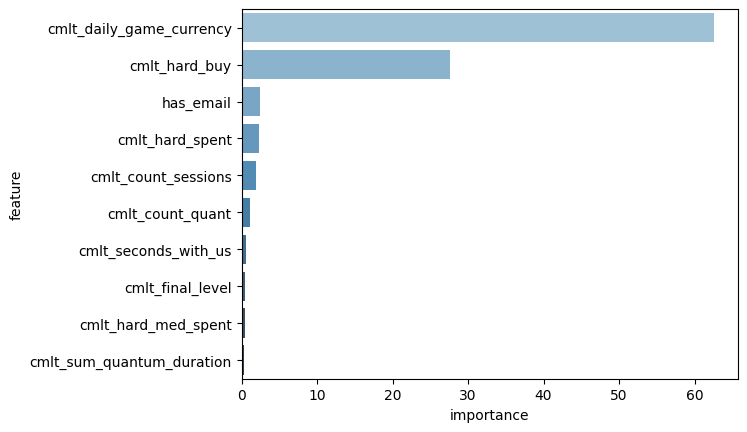

In [34]:
params = {
    'iterations': 230,
    'depth': 3,
    'loss_function': 'MAE',
    'random_state': 42,
    'l2_leaf_reg': 20,
    'verbose': 50,
    'early_stopping_rounds': 20,
    'thread_count': -1
}

model, features = train_model(CatBoostRegressor(**params),
                              X_train, 
                              y_train,
                              5,
                              scoring='neg_mean_absolute_error',
                              cross_val=True)

In [35]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [36]:
print('Train SMAPE: ', SMAPE(y_train, y_pred_train))
print('Test SMAPE: ', SMAPE(y_test, y_pred_test))

print('Train RMSE: ',  np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('Test RMSE: ',  np.sqrt(mean_squared_error(y_test, y_pred_test)))

print('Train MAE: ',  mean_absolute_error(y_train, y_pred_train))
print('Test MAE: ',  mean_absolute_error(y_test, y_pred_test))

Train SMAPE:  1.9775113990451205
Test SMAPE:  1.9779116425657624
Train RMSE:  8313.044680082789
Test RMSE:  7197.929424031383
Train MAE:  427.50223179291436
Test MAE:  378.8722657599412
